In [1]:
import pandas as pd

import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from collections import defaultdict
import time


df_r = pd.read_csv("data_for_science_KT_train.csv", encoding='utf-8', sep=',')
df_r.head()

,idx,DATE,KT_RESULT
0,301478,2020-04-17,КТ-1
1,18024,2020-04-17,КТ-0
2,191578,2020-04-17,КТ-1
3,215212,2020-04-18,КТ-1
4,689401,2020-04-18,КТ-2


In [2]:
df_r = df_r.sort_values("DATE", kind="stable")

In [3]:
df_r["y"] = df_r.KT_RESULT.apply(lambda x: int(x.split('-')[1]))
df_r.head()

,idx,DATE,KT_RESULT,y
0,301478,2020-04-17,КТ-1,1
1,18024,2020-04-17,КТ-0,0
2,191578,2020-04-17,КТ-1,1
39305,623270,2020-04-17,КТ-2,2
39306,327426,2020-04-17,КТ-0,0


In [4]:
df_a = pd.read_csv("data_for_science_2020-07-27_w_mu_type.csv", encoding='utf-8', sep=';')

In [5]:
def parseDate(str_date):
    if(isinstance(str_date, str)==False):
        return 0
    
    s = str_date.split('-')
    day = s[2]
    month = s[1]
    year=s[0]
    
    list_of_month = ["01", "02", "03", "04", "05","06","07", "08", "09", "10", "11", "12"]

    month = list_of_month.index(month) + 1
    
    day = int(day[1])  if(day[0]=='0') else int(day)
    
    year = int(year)
    
    st = time.struct_time(
    (year, month, day, 0, 0, 0, 0, 0, 0)
    )
    
    return time.mktime(st)


In [6]:
def parseYear(str_date):
    if(isinstance(str_date, str)==False):
        return 0
    
    year = str_date.split('-')[0]
    year = int(year)
    
    return year 


class SimpleYearExtractor(BaseEstimator, TransformerMixin):
  def __init__(self, table):
    
    birth_dates = table[["idx", "birth_dt"]].groupby("idx").min().reset_index()
    birth_dates["year"] = birth_dates.birth_dt.apply(parseYear)
    self.dates = birth_dates[["idx", "year"]].copy()
    
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    
    return X.merge(self.dates, how='left', on='idx')[["year"]]

In [7]:
#SimpleYearExtractor(df_a).fit_transform(df_r)

In [8]:
class SimpleCountExtractor(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
    
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    rez = X[["idx", "DATE"]].copy()

    groupby_object = X[["idx"]].groupby('idx')
    #how many ct patient had
    rez["count"] = groupby_object['idx'].transform(len)
    #CT's number
    rez["cum_count"] = groupby_object.cumcount()+1
    #CT's reverse number
    rez["count_ost"] = rez["count"].values - rez["cum_count"].values

    
    return rez[["cum_count", "count", 'count_ost']]

In [9]:
class SimpleTimeExtractor(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
    
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    rez = X.copy()

    rez["time"] = rez.DATE.apply(parseDate)
    groupby_object = rez.groupby('idx')
    
    #how many СT patient had
    rez["count"] = groupby_object['idx'].transform(len)
    #time to next CT
    rez["prev_time_dif"] = groupby_object['time'].diff(1).fillna(-1)
    #Time to prev CT
    rez["next_time_dif"] = groupby_object['time'].diff(-1).fillna(1)
    
    #count statistics only where it make sense
    rez_filtered = rez[(rez["count"] > 1)&(rez["prev_time_dif"] != -1)]#.copy()
    
    #mean and std time differnces between patient's CTs
    patient_time_stats = rez_filtered[["idx", "prev_time_dif"]].groupby('idx').agg(
         time_mean = pd.NamedAgg(column="prev_time_dif", aggfunc=np.mean),
         time_std = pd.NamedAgg(column="prev_time_dif", aggfunc=np.std)).reset_index()

    rez = rez.merge(patient_time_stats, on="idx", how="left").fillna(-1)

    return rez[["idx", "time", "prev_time_dif", "next_time_dif", "time_mean", "time_std"]]

In [10]:
class SimpleGenderExtractor(BaseEstimator, TransformerMixin):
  def __init__(self, table):
    #data is very noisy. There are people who change their gender from row to row. 
    #So, lets choose most common gender for every patient from rows where he is presented.
    gender = table[["idx", "gender"]].groupby("idx").agg(pd.Series.mode).reset_index()
    gender["gender"] = gender.gender.apply(lambda x: 1 if(x=='М') else 0)
    self.gender = gender[["idx", "gender"]].copy()
    
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    return X.merge(self.gender, how='left', on='idx')[["gender"]] #.values.tolist()

In [11]:
#SimpleGenderExtractor(df_a).fit_transform(df_r)

In [12]:
def generate_nearesttime_table(df, X, time_field):
    
    #generate sequence numbers of CT and analysis
    df = df.sort_values(time_field)
    df["cumcount_df"] = df.groupby('idx').cumcount()


    X["cumcount_X"] = X.groupby('idx').cumcount()
    X["DATE"] = X["DATE"].apply(parseDate) 
    
    #cartesian product inside groups
    combined = X.merge(df, on = "idx", how="left")
    
    #choose nearest analysis to CT
    combined["time_dif"] = np.abs(combined[time_field].values - combined.DATE.values)
    nearest_table = combined[["idx", "cumcount_X", "cumcount_df", "time_dif"]].set_index("cumcount_df").groupby(["idx", "cumcount_X"]).idxmin()
    
    nearest_table = nearest_table.reset_index()
    
    nearest_table = nearest_table[~nearest_table.time_dif.isna()].copy()
    
    nearest_table["cumcount_df"] = nearest_table["time_dif"].astype("int")
    
    return df, X, nearest_table[["idx", "cumcount_X", "cumcount_df"]]


def match_features(match_table, feautes_table, feature_names, new_names):
    rename_dict = dict(zip(feature_names, new_names))
    features = match_table[["idx", "cumcount_X", "cumcount_df"]].merge( feautes_table[["idx", "cumcount_df"] + feature_names],                                             
                                                          on = ["idx", "cumcount_df"], how = "left")
    
    features = features.rename(columns = rename_dict)
    
    return features[["idx", "cumcount_X"] + new_names]


class NearAntiBodyExtractor(BaseEstimator, TransformerMixin):
  def __init__(self, table):
    self.data = table[table["samples_type_id"]=='Кровь, цельная (сыворотка)'][["idx", "get_date_at", "IgG", "IgM"]]#.copy()

    self.time_field = "get_date_at"
    
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X = X.copy()
    df = self.data[self.data.idx.isin(set(X.idx))].copy()
    
    df[self.time_field] = df[self.time_field].apply(parseDate)  
    
    #find the nearest analysis and one before and one after
    df, X, match_table = generate_nearesttime_table(df, X, self.time_field)
    
    current = match_features(match_table, df, ["get_date_at", 'IgG', 'IgM'], ["td_blood_a", 'IgG', 'IgM'])
    match_table["cumcount_df"] -= 1
    backward = match_features(match_table, df, ["get_date_at", 'IgG', 'IgM'], ['td_bloodb', 'IgGb', 'IgMb'])
    match_table["cumcount_df"] += 2
    forward = match_features(match_table, df, ["get_date_at", 'IgG', 'IgM'], ['td_bloodf', 'IgGf', 'IgMf'])
    
    features = current.merge(backward, how="left", on=["idx", "cumcount_X"]).merge(forward, how="left", on=["idx", "cumcount_X"])
    
    features = features.merge(X[["idx", "cumcount_X", "DATE"]], how="left", on=["idx", "cumcount_X"])
    
    #change absolute time on relative time differences
    features["td_bloodb"] = np.abs(features.td_bloodb - features.td_blood_a)
    features["td_bloodf"] = np.abs(features.td_bloodf - features.td_blood_a)
    features["td_blood_a"] = np.abs(features.DATE - features.td_blood_a)
    
    features = X.merge(features.drop(["DATE"], axis=1), how="left", on=["idx", "cumcount_X"])
    
    #out of bound Nan coding
    return features[['td_blood_a', 'IgG', 'IgM', 'td_bloodb', 'IgGb', 'IgMb', 'td_bloodf', 'IgGf', 'IgMf']].fillna(-10**9)


In [13]:
#NearAntiBodyExtractor(df_a).fit_transform(df_r)

In [14]:
md = pd.read_csv("data_for_science_death_2020-07-27.csv", sep=';')

#time between patient's CT and his death

class TTDExtractor(BaseEstimator, TransformerMixin):
  def __init__(self, table):
    self.de = table.copy()
    
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X = X.copy()
    
    #Dataset have people with more than one CT in the same day 
    X["id"] = np.arange(len(X)) 
    
    md = X.merge(self.de, on="idx", how="inner")
    
    md["ttd"] = md.DEATH_DATE.apply(parseDate) - md.DATE.apply(parseDate)
    md = md.drop_duplicates()
    
    rez = X.merge(md[["id", "ttd"]], on="id", how="left").fillna(-1)
    
    return rez[["ttd"]]

In [15]:
df_d = pd.read_csv("data_for_science_LIs_2020-07-27.csv", encoding='utf-8', sep=';')

In [17]:
def parseValue(value):
    bs = ('-', '----', '--')
    val = value.split('_')[0].replace(',','.')
    
    try:
        return float(val)
    except ValueError:
        return -1

def process_features(df, top_k, test2id):
    l = [-1.0]*(len(top_k)+1)
    tim = df.TEST_TIME.values[0]
    
    #l[0] = idx
    l[0] = parseDate(tim.split()[0])
    
    for name, value in zip(df.FIXED_NAME, df.TEST_VAL):
        if(name in test2id):
            l[test2id[name] + 1] = parseValue(value)

    return pd.Series(data=l, index=(["get_date_at"] + top_k[::]))


class NearImprovedBloodExtractor(BaseEstimator, TransformerMixin):
  def __init__(self, table, k):
    
    bloods = ["Общий клинический анализ крови (общий анализ + СОЭ + лейкоцитарная формула + тромбоциты)",
          "Общий клинический анализ крови (общий анализ + СОЭ), микроскопическое исследование мазка крови при выявлении патологии",
          "Общий клинический анализ крови (скрининг)",
          "Клинический анализ крови"]

    table = table[table.ISSL_NAME.isin(bloods)].copy()
    table["FIXED_NAME"] = table["TEST_NAME"].apply(lambda x:x.split('(')[0].strip())
    
    #determine most common values in analyses
    series = table.FIXED_NAME.value_counts()
    
    self.top_k = []
    self.k = k
    
    for i, x in enumerate(series.index):
        if(i<k):
            self.top_k.append(x)
        else:
            break
            
            
            
    #determine values order
    self.test2id = {k:i for i, k in enumerate(self.top_k)}
    
    #for each patient transform each anlysis in more convinient form and save into a table
    
    self.tbp = table.groupby(by = ["idx", "TEST_TIME"]).apply(lambda x: process_features(x, self.top_k, self.test2id)).reset_index()
    
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X = X.copy()
    
    df = self.tbp[self.tbp.idx.isin(set(X.idx))].copy()

    #find the nearest analysis 
    time_field = "get_date_at" 

    df, X, match_table = generate_nearesttime_table(df, X, time_field)
    
    #match KT with near analysis
    features = match_table.merge(df, on = ["idx", "cumcount_df"], how = "left")
    ans = X.merge(features, on = ["idx", "cumcount_X"], how = "left")
    
    #fix time, get right columns, fill Nan out of bound
    ans["td_blood"] = np.abs(ans["DATE"].values - ans["get_date_at"].values)
    
    feature_names = ["td_blood"] + self.top_k
    
    return ans[feature_names].fillna(-10**9)

    

In [18]:
#C protein was one of the most important feature in the competition
#I extracted information about 3 nearest results to CT.
class NearCproteinExtractor(BaseEstimator, TransformerMixin):
  def __init__(self, table):
    self.table = table[table.ISSL_NAME == "Определение белков острой фазы С-реактивный белок"].copy()

  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    #TODO в оригинале были разницы С с центральным без модулей.
    X = X.copy()
    df = table[table.idx.isin(set(X.idx))].copy()

    time_field = "TEST_TIME"

    df[time_field] = df[time_field].apply(lambda tim: parseDate(tim.split()[0]))

    df = df[["idx", "TEST_VAL", time_field]]
    df["TEST_VAL"] = df["TEST_VAL"].apply(parseValue)
    
    
    #find the nearest C protein analysis
    df, X, match_table = generate_nearesttime_table(df, X, time_field)
    
    #retrieve information about the nearest, one before and one after
    current = match_features(match_table, df, ["TEST_TIME", "TEST_VAL"], ["td_C", "C"])
    match_table["cumcount_df"] -= 1
    backward = match_features(match_table, df, ["TEST_TIME", "TEST_VAL"], ["td_C_backward", "C_backward"])
    match_table["cumcount_df"] += 2
    forward = match_features(match_table, df, ["TEST_TIME", "TEST_VAL"], ["td_C_forward", "C_forward"])
    
    #calculate time differences
    features = current.merge(backward, how="left", on=["idx", "cumcount_X"]).merge(forward, how="left", on=["idx", "cumcount_X"])

    features = features.merge(X[["idx", "cumcount_X", "DATE"]], how="left", on=["idx", "cumcount_X"])
    
    
    features["td_C_backward"] = np.abs(features.td_C - features.td_C_backward)
    features["td_C_forward"] = np.abs(features.td_C - features.td_C_forward)
    features["td_C"] = np.abs(features.DATE - features.td_C)
    
    
    features = X.merge(features.drop(["DATE"], axis=1), how="left", on=["idx", "cumcount_X"])
    
    
    
    return features[["td_C", "C", "td_C_backward", "C_backward", "td_C_forward", "C_forward"]].fillna(-10**9)
    

    
    
    

In [19]:
import numpy as np
df_diag = pd.read_csv("data_for_science_diagnoses_2020-07-27.csv", sep=';')

#Does patient have any chronical disease
class VerySimpleDiasesExctractor(BaseEstimator, TransformerMixin):
  def __init__(self, table):
    self.I_pat = set(table[table.DIAGNOSIS.apply(lambda x:x[0]=='I')].idx) 
    self.E_pat = set(table[table.DIAGNOSIS.apply(lambda x:x[0]=='E')].idx)
    
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X = X.copy()
    d = {'I':np.zeros((len(X),)), 'E':[0]*np.zeros((len(X),)) }
    d['I'][X.idx.isin(self.I_pat)] = 1
    d['E'][X.idx.isin(self.E_pat)] = 1
    
    return pd.DataFrame.from_dict(d) #.values.tolist()

In [20]:
#obtain information about patien resperatory diseases in "bag of words" form
#use time between diagnosis and CT instead of ones 
def extractTime2diag(d, top_k, test2id, x):
    if(x["idx"] in d):
        dd = d[x["idx"]]
        vals = np.zeros((len(top_k), )) - 10**9 
        for k, v in dd.items():
            dif = np.array(v)
            diffs = x["time"] - dif
            vals[test2id[k]] = diffs[np.abs(diffs).argsort()[0]] #.min()
        
        return pd.Series(data=vals, index=top_k[::])
    else:
        return pd.Series(data=[-10**9]*len(top_k), index=top_k[::])

#I assumed that chronic resperatory diseases have the greatest impact on covid severity
#so I extracted more detailed information about them
class ResperatoryDiasesExctractor(BaseEstimator, TransformerMixin):
  def __init__(self, table, k):
    table = table[table.DIAGNOSIS.apply(lambda x:x[0]=='J')].copy()
    series = table.DIAGNOSIS.value_counts()
    
    self.top_k = []
    
    #choose top k most common resperatory diseases

    for i, x in enumerate(series.index):
        if(i<k):
            self.top_k.append(x)
        else:
            break

    self.test2id = {k:i for i, k in enumerate(self.top_k)}
    
    #Transform table to dict
    
    self.d = {}
    for idx, g in table.groupby("idx"):
        self.d[idx] = {}
        for tim, diag in zip(g.DATE, g.DIAGNOSIS):
            pt = parseDate(tim.split()[0])
            if(diag not in self.top_k):
                continue
            if diag in self.d[idx]:
                self.d[idx][diag].append(pt)
            else:
                self.d[idx][diag] = [pt]
                
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X = X.copy()
    X["time"] = X.DATE.apply(parseDate)
    
    return X.apply(lambda x: extractTime2diag(self.d, self.top_k, self.test2id, x), axis=1) #.values.tolist()
    

In [21]:
#minimum aggregation of previous features group by time. 
#Return time when a disease was diagnosed and categorical encoded disease

def extractNearestDisease(d, top_k, test2id, x):
    if(x["idx"] in d):
        dd = d[x["idx"]]
        vals = np.zeros((len(top_k), )) - 10**9 
        for k, v in dd.items():
            dif = np.array(v)
            diffs = x["time"] - dif
            vals[test2id[k]] = diffs[np.abs(diffs).argsort()[0]] #.min()
            
        min_i = np.abs(vals).argsort()[0]
        md = vals[min_i]
        
        return pd.Series(data=[md, min_i], index=["time2near_diag", "near_diag"])
    else:
        return pd.Series(data=[-10**9]*2, index=["time2near_diag", "near_diag"])

class ResperatoryDiasesNearExctractor(BaseEstimator, TransformerMixin):
  def __init__(self, table, k):
    table = table[table.DIAGNOSIS.apply(lambda x:x[0]=='J')].copy()
    series = table.DIAGNOSIS.value_counts()
    self.top_k = []

    for i, x in enumerate(series.index):
        if(i<k):
            self.top_k.append(x)
        else:
            break

    self.test2id = {k:i for i, k in enumerate(self.top_k)}

    self.d = {}
    for idx, g in table.groupby("idx"):
        self.d[idx] = {}
        for tim, diag in zip(g.DATE, g.DIAGNOSIS):
            pt = parseDate(tim.split()[0])
            if(diag not in self.top_k):
                continue
            if diag in self.d[idx]:
                self.d[idx][diag].append(pt)
            else:
                self.d[idx][diag] = [pt]
                
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X = X.copy()
    X["time"] = X.DATE.apply(parseDate)
    X = X.apply(lambda x: extractNearestDisease(self.d, self.top_k, self.test2id, x), axis=1) 
    return X

In [22]:
#other disease I percieved as not very important. So, for them I encoded only the nearest diagnosed disease 

class OtherDiasesNearExctractor(BaseEstimator, TransformerMixin):
  def __init__(self, table, k):
    table = table[table.DIAGNOSIS.apply(lambda x:(x[0]=='E')|(x[0]=='I'))].copy()
    series = table.DIAGNOSIS.value_counts()
    
    self.top_k = []

    for i, x in enumerate(series.index):
        if(i<k):
            self.top_k.append(x)
        else:
            break

    self.test2id = {k:i for i, k in enumerate(self.top_k)}

    self.d = {}
    for idx, g in table.groupby("idx"):
        self.d[idx] = {}
        for tim, diag in zip(g.DATE, g.DIAGNOSIS):
            pt = parseDate(tim.split()[0])
            if(diag not in self.top_k):
                continue
            if diag in self.d[idx]:
                self.d[idx][diag].append(pt)
            else:
                self.d[idx][diag] = [pt]
                
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X = X.copy()
    X["time"] = X.DATE.apply(parseDate)
    X = X.apply(lambda x: extractNearestDisease(self.d, self.top_k, self.test2id, x), axis=1) 
    
    return X

In [23]:
df_drug = pd.read_csv('data_for_science_drugs_2020-07-27.csv', encoding='utf-8', sep=';')

In [24]:
from collections import Counter
import itertools

#some patients have prescriptions. I encoded that with bag of words. I left only the nearest prescription for each CT.

def bagOfWordsRecipe(d, drugs, x):
    if(x["idx"] in d):
        
        dif = np.array([y[0] for y in d[x["idx"]]])
        
        diffs = x["time"] - dif
        min_i = np.argsort(np.abs(diffs))[0]
        
        df = diffs[min_i]
        rv = [df] + (d[x["idx"]][min_i][1:]) + [len(dif)]
        
        return pd.Series(data=rv, index=(["td_Rec"] + drugs + ["n_recep"]))
    else:
        return pd.Series(data=[-10**9] + [0]*(len(drugs)+1), index=(["td_Rec"] + drugs + ["n_recep"]))

#clear string
def delSym(st):
    s = set({'!', '#',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/', 
 ':',
 ';',
 '<',
 '=',
 '>',
 '?', 
 '[',
 '\\',
 ']',
 '^',
 '_',})
    return ''.join([x if x not in s else ' ' for x in st])

class ReceipeExtractor(BaseEstimator, TransformerMixin):
  def __init__(self, df_drugs, t_hold = 5):
    
    #I left only tokens with count higher than t_hold value
    rep = df_drug.RECIPE.apply(lambda x: delSym(x).split()).tolist()
    mc = Counter(list(filter(lambda x:x[0].isupper(), itertools.chain.from_iterable(rep)))).most_common()
    self.drugs = [x for x, c in mc if c>t_hold]
    s_drugs = set(self.drugs)
    test2id = {k:i for i, k in enumerate(self.drugs)}
    
    #gather information from table to more convinient form in dict
    self.d = {}
    for idx, g in df_drug.groupby("idx"):
        self.d[idx] = []
        for tim, gg in g.groupby("DATE"):
            val = ' '.join(gg.RECIPE.tolist())
            l = [0]*(len(self.drugs)+1)
            l[0] = parseDate(tim.split()[0])
            for t in delSym(val).split():
                if t in s_drugs:
                    l[test2id[t]] = 1
            self.d[idx].append(l)
    
    
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X = X.copy()
    X["time"] = X.DATE.apply(parseDate)
    
    return X.apply(lambda x: bagOfWordsRecipe(self.d, self.drugs, x), axis=1) #.values.tolist()

In [25]:
#Was a patient hospitalized 
class HospitalFlagExtractor(BaseEstimator, TransformerMixin):
  def __init__(self, table):
    self.hosp_id = set(df_a[df_a.mu_type.apply(lambda x: 'больница' in x)].idx)
    
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X = X.copy()
    X["hosp"] = X.idx.apply(lambda x: 1 if x in self.hosp_id else 0)
    return X[["hosp"]] #.values.tolist()

In [26]:
#Swabs data is very nosy and results do not correlate with severity
#Time data have the least noise. And therefore I  meticulously generated features based on time

#Time between first and last swab, mean time and std between swab.

#Also instituion where swabs was gotten is quiet reliable. I also retirieved that.

#Swabs results is rather noisy but I also added them just in case

def mazokStatFunction(d, header, infty, x):
    if(x["idx"] in d):
        places = d[x["idx"]][1]
        pf = []
        pfn = []
        for p in places:
            if(len(p)==0):
                pf.append(infty)
                pfn.append(0)
            else:
                dif = np.array(p)
                diffs = np.abs(x["time"] - dif)
                near_id =  diffs.argsort()[0]
                pf.append(x["time"] - dif[near_id])
                pfn.append(len(diffs))
        
        trues = d[x["idx"]][2]
        if (len(trues) == 0):
            tf = infty
        else:
            dif = np.array(trues)
            diffs = np.abs(x["time"] - dif)
            near_id =  diffs.argsort()[0]
            tf = x["time"] - dif[near_id]
        
        features = d[x["idx"]][0][::]
        
        features[1] = features[1] - x["time"]
        features[2] = features[2] - x["time"]
        
        features += (pf + pfn)
        features += [tf]
        
        
        return pd.Series(data= features , index=header)
    else:
        return pd.Series(data=[-1]*len(header), index=header)

class MazokExctractor(BaseEstimator, TransformerMixin):
  def __init__(self, table):
    
    table = table[table.samples_type_id == 'Мазок/отделяемое из носоглотки и ротоглотки']
    self.top_k = []
    k = 20
    series = table.mu_type.value_counts()

    for i, x in enumerate(series.index):
        if(i<k):
            self.top_k.append(x)
        else:
            break
            
    self.ot2id = {k:i for i, k in enumerate(self.top_k)}
    self.top_k_n = [x+'_n' for x in self.top_k]

            
    self.d = {}
    for idx, g in table.groupby("idx"):
        times = g.get_date_at.apply(parseDate)
        if(len(g)==0):
            continue
        n = len(times)
        mi = times.min()
        ma = times.max()

        if(n != 1):
            dif = np.diff(times)
            mean = dif.mean()
            std = dif.std()
        else:
            mean = -1
            std = -1

        ob_flag = []

        for x, tim in zip(g.samples_result_id, g.get_date_at):
            if x == 'ОБНАРУЖЕНО':
                ob_flag.append(parseDate(tim))

        place = [[] for _ in range(len(self.top_k))]

        for x, tim in zip(g.mu_type, g.get_date_at):
            place[self.ot2id[x]].append(parseDate(tim))

        features = [n, mi, ma, ma-mi, mean, std]

        self.d[idx] = (features, place, ob_flag)
        
    self.infty = -10**9
    self.header = ["n", "tt_min", "tt_max", "max-min", "mean", "std"] + self.top_k + self.top_k_n + ["tt_true"]

    
    
        
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X = X.copy()
    X["time"] = X.DATE.apply(parseDate)
    
    return X.apply(lambda x: mazokStatFunction(self.d, self.header, self.infty, x), axis=1) #.values.tolist()

In [27]:
# Extract features from time of antibody blood tests. Just in case. 
def antibodyStatFunction(d, header, infty, x):
    if(x["idx"] in d):
        places = d[x["idx"]][1]
        pf = []
        pfn = []
        for p in places:
            if(len(p)==0):
                pf.append(infty)
                pfn.append(0)
            else:
                dif = np.array(p)
                diffs = np.abs(x["time"] - dif)
                near_id =  diffs.argsort()[0]
                pf.append(x["time"] - dif[near_id])
                pfn.append(len(diffs))
        
        
        features = d[x["idx"]][0][::]
        
        features[1] = features[1] - x["time"]
        features[2] = features[2] - x["time"]
        
        features += (pf + pfn)
        
        return pd.Series(data= features , index=header)
    else:
        return pd.Series(data=[-1]*len(header), index=header)

class AntibodyStatExctractor(BaseEstimator, TransformerMixin):
  def __init__(self, table):
    
    table = table[table.samples_type_id == 'Кровь, цельная (сыворотка)']
    self.top_k = []
    k = 20
    series = table.mu_type.value_counts()

    for i, x in enumerate(series.index):
        if(i<k):
            self.top_k.append(x)
        else:
            break
            
    self.ot2id = {k:i for i, k in enumerate(self.top_k)}
    self.top_k_n = [x+'_n' for x in self.top_k]

            
    self.d = {}
    for idx, g in table.groupby("idx"):
        times = g.get_date_at.apply(parseDate)
        if(len(g)==0):
            continue
        n = len(times)
        mi = times.min()
        ma = times.max()

        if(n != 1):
            dif = np.diff(times)
            mean = dif.mean()
            std = dif.std()
        else:
            mean = -1
            std = -1

        place = [[] for _ in range(len(self.top_k))]

        for x, tim in zip(g.mu_type, g.get_date_at):
            place[self.ot2id[x]].append(parseDate(tim))

        features = [n, mi, ma, ma-mi, mean, std]

        self.d[idx] = (features, place)
        
    self.infty = -10**9
    self.header = ["n", "tt_min", "tt_max", "max-min", "mean", "std"] + self.top_k + self.top_k_n

    
    
        
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X = X.copy()
    X["time"] = X.DATE.apply(parseDate)
    
    return X.apply(lambda x: antibodyStatFunction(self.d, self.header, self.infty, x), axis=1) #.values.tolist()

In [30]:
#we extracts here which diseases therepists assumed when they got swabs and blood test.
#how long that diseases was diagnosed, how many times eash disease was assumed 
#that information quiet noisy and not very reliable but may have some impact on predictions

def diseaseStatExtractor(d, code2id, header, x):
    if(x["idx"] in d):
        
        dd = d[x["idx"]]
        features = [-10**9]*(len(header)//2)
        features_n = [0]*(len(header)//2)
        
        for k, v in dd.items():            
            dif = np.array(v)
            
            diffs = x["time"] - dif
            near_id =  np.abs(diffs).argsort()[0]
            
            if not (k in code2id):
                features[-1]  =  diffs[near_id]
                features_n[-1] += len(dif)
            else:
                features[code2id[k]] = diffs[near_id]
                features_n[ code2id[k] ] = len(dif)
        
        sn = sum(features)
        features_n = [x/sn for x in features_n]
        
        return pd.Series(data= features + features_n, index=header)
    else:
        return pd.Series(data=[-10**9]*len(header), index=header)

    
class ReasonExctractor(BaseEstimator, TransformerMixin):
  def __init__(self, table, th = 4):
    self.d = {}
    self.th = th
    for idx, g in table.groupby("idx"):
        self.d[idx] = {}
        for tim, code in zip(g.get_date_at, g.mkb10_code):
            if code in self.d[idx]:
                self.d[idx][code].append(parseDate(tim))
            else:
                self.d[idx][code] = [parseDate(tim)]
    
        
  def fit(self, X, y = None):
    df_r = X.copy()
    s = set(df_r.idx)
    tb = df_a[df_a.idx.isin(s)]
    tb = tb[["idx", "mkb10_code"]].drop_duplicates()
    good_code = []
    #filter most common diseases
    series = tb.mkb10_code.value_counts()
    for i in series.index:
        if(series[i]>self.th):
            good_code.append(i)
    
    self.code2id = {code:i for i, code in enumerate(good_code)}
    #header of resulting dataset. times + counts + stats about rare diseases
    self.header = good_code + [x+'_n' for x in good_code] + ["rare"] + ["rare_n"]
    
    return self

  def transform(self, X, y = None):
    X = X.copy()
    X["time"] = X.DATE.apply(parseDate)
    
    return X.apply(lambda x: diseaseStatExtractor(self.d, self.code2id, self.header, x), axis=1) #.values.tolist()

In [43]:
# Extract the nearest assumed diagnosis to CT
def nearAssumeExtracor(d, code2id, header, x):
    if(x["idx"] in d):
        
        dd = d[x["idx"]]
        features = [-10**9]*len(header)
        
        for k, v in dd.items():
            k = k[0]
            dif = np.array(v)
            
            diffs = x["time"] - dif
            near_id =  np.abs(diffs).argsort()[0]
            
            if not (k in code2id):
                features[-1]  =  diffs[near_id]
            else:
                features[code2id[k]] = diffs[near_id]
        
            
        
        return pd.Series(data= features , index=header)
    else:
        return pd.Series(data=[-10**9]*len(header), index=header)

    
class ReasonExctractorLatter(BaseEstimator, TransformerMixin):
  def __init__(self, table, th = 4):
    self.d = {}
    self.th = th
    for idx, g in table[["idx","get_date_at", "mkb10_code"]].fillna('#').groupby("idx"):
        self.d[idx] = {}
        for tim, code in zip(g.get_date_at, g.mkb10_code):
            #print(code)
            code = code[0]
            if code in self.d[idx]:
                self.d[idx][code].append(parseDate(tim))
            else:
                self.d[idx][code] = [parseDate(tim)]
    
        
  def fit(self, X, y = None):
    df_r = X.copy()
    s = set(df_r.idx)
    tb = df_a[df_a.idx.isin(s)]
    tb = tb[["idx", "mkb10_code"]].drop_duplicates().copy()
    tb["code"] = tb.fillna('#').mkb10_code.apply(lambda x:x[0])
    good_code = []
    series = tb.code.value_counts()
    for i in series.index:
        if(series[i]>self.th):
            good_code.append(i)
    
    self.code2id = {code:i for i, code in enumerate(good_code)}
    self.header = good_code + ["rare"]
    
    return self

  def transform(self, X, y = None):
    X = X.copy()
    X["time"] = X.DATE.apply(parseDate)
    
    return X.apply(lambda x: nearAssumeExtracor(self.d, self.code2id, self.header, x), axis=1) #.values.tolist()

In [44]:
#ReasonExctractorLatter(df_a).fit_transform(df_r)

In [45]:
q = pd.read_csv("data_for_science_questions_2020-07-27.csv", sep=';')
#Did a patient answer the questionare about Covid 19.
class QuestionExctractor(BaseEstimator, TransformerMixin):
  def __init__(self, table):
    series = table.idx.value_counts()
    self.d = dict(zip(series.index, series.values))
        
  def fit(self, X, y = None):
    
    return self

  def transform(self, X, y = None):
    X  = X.copy()
    X["questions"] = X.idx.apply(lambda x: self.d[x] if x in self.d else -1)
    
    return X[["questions"]]

In [47]:
#It is a special analysis which is taken from a patient only if he is hospitalyzed
#Not very much people in the datset have them. But it may have some impact on predictions

def baseFeatExtract(d, top_k, x):
    
    if(x["idx"] in d):
        
        dif = np.array([y[0] for y in d[x["idx"]]])
        
        diffs = x["time"] - dif
        min_i = np.argsort(np.abs(diffs))[0]
        
        df = diffs[min_i]
        rv = [df] + (d[x["idx"]][min_i][1:])
        
        return pd.Series(data=rv, index=(["td_blood"] + top_k[::]))
    else:
        return pd.Series(data=[-10**9]*(len(top_k)+1), index=(["td_blood"] + top_k[::]))


class NearDdimerExtractor(BaseEstimator, TransformerMixin):
  def __init__(self, table):
    k=1

    table = table[table.ISSL_NAME == "D-димер"]

    series = table.TEST_NAME.value_counts()
    
    self.top_k = []
    self.k = k

    for i, x in enumerate(series.index):
        if(i<k):
            self.top_k.append(x)
        else:
            break

    self.test2id = {k:i for i, k in enumerate(self.top_k)}
    
    self.d = {}
    for idx, g in table.groupby("idx"):
        self.d[idx] = []
        for tim, gg in g.groupby("TEST_TIME"):
            #print(gg)
            l = [-1.0]*(len(self.top_k)+1)
            l[0] = parseDate(tim.split()[0])
            for name, value in zip(gg.TEST_NAME, gg.TEST_VAL):
                if(name in self.test2id):
                    l[self.test2id[name]+1] = parseValue(value)
            
            
            

            self.d[idx].append(l)
    
    
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X = X.copy()
    X["time"] = X.DATE.apply(parseDate)
    
    return X.apply(lambda x: baseFeatExtract(self.d, self.top_k, x), axis=1) #.values.tolist()

class NearFerrumExtractor(BaseEstimator, TransformerMixin):
  def __init__(self, table):
    k=1

    table = table[table.ISSL_NAME == "Исследование ферритина"]

    series = table.TEST_NAME.value_counts()
    
    self.top_k = []
    self.k = k

    for i, x in enumerate(series.index):
        if(i<k):
            self.top_k.append(x)
        else:
            break

    self.test2id = {k:i for i, k in enumerate(self.top_k)}
    
    self.d = {}
    for idx, g in table.groupby("idx"):
        self.d[idx] = []
        for tim, gg in g.groupby("TEST_TIME"):
            #print(gg)
            l = [-1.0]*(len(self.top_k)+1)
            l[0] = parseDate(tim.split()[0])
            for name, value in zip(gg.TEST_NAME, gg.TEST_VAL):
                if(name in self.test2id):
                    l[self.test2id[name]+1] = parseValue(value)
            
            
            

            self.d[idx].append(l)
    
    
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X = X.copy()
    X["time"] = X.DATE.apply(parseDate)
    
    return X.apply(lambda x: baseFeatExtract(self.d, self.top_k, x), axis=1) 

In [48]:
from sklearn.metrics import make_scorer
import random

#Competition had sofisticated metric function for ordinals.
#This score function is sort of hybrid between classification and regression.
#Below you can see its implementation

def score_func(y_true, y_pred):
    nu = [4, 3, 2, 3, 4]
    rez = 0
    
    for i in range(5):
        y = y_pred[y_true == i]
        rez += np.abs(i-y).mean()/nu[i]
        
    return 1 - rez/5

scorer = make_scorer(score_func, greater_is_better=True)

In [49]:
my_custom_loss_func([0, 1, 2, 3, 4], [0, 1, 2, 1, 0])

0.33333333333333337

In [50]:
#We can derive next things from EDA:
#1) train and test do not intersect by patients
#2) Train and test was collected in the same time interval.
#3) Classes distribution do not change from train to test
#4) Train is 3 time greater than test

#let's built our validtion keeping that in mind. I used simple 4-fold cross validation by patients 
def custom_cv(train):
    l = list(set(train.idx))
    random.shuffle(l)
    for sp  in np.array_split(np.array(l), 4):
        s = set(sp)
        yield (train[~train.idx.isin(s)].index.values, train[train.idx.isin(s)].index.values)

In [51]:
from sklearn.pipeline import FeatureUnion

#gather continious features

#+0.664
transformer_list = [("year", SimpleYearExtractor( df_a)), #1
                      ("counts", SimpleCountExtractor() ), #2
                      ("times", SimpleTimeExtractor() ), #3
                      ("gender", SimpleGenderExtractor(df_a)), #1 0.669
                      ("antibody", NearAntiBodyExtractor(df_a)), #3 0.70
                      ("TTD", TTDExtractor(md)), #1 0.703
                      ("C-protein", NearCproteinExtractor(df_d)), #2 0.720
                      ("Simple Blood", NearImprovedBloodExtractor(df_d, 40)), #41 0.725
                      ("History Diases", VerySimpleDiasesExctractor(df_diag)), #2 0.726
                      ("Respiratory Diases", ResperatoryDiasesExctractor(df_diag, 100)), #100 74.2
                      ("Receipe", ReceipeExtractor(df_drug, 5)), #75.2 важен факт выписывания рецепта и гидрохлорин
                      ("Mazok", MazokExctractor(df_a) ),  # 77.3\
                      ("Reason", ReasonExctractor(df_a)),
                      ("Question", QuestionExctractor(q)),
                      ("D-dimer", NearDdimerExtractor(df_d) ), 
                      ("Ferrum", NearFerrumExtractor(df_d)), 
                      ("Antibody Stat", AntibodyStatExctractor(df_a))
                      ]
                    
union = FeatureUnion(transformer_list, verbose = 1)

In [52]:
from lightgbm import LGBMRegressor
X_train = union.fit_transform(df_r)

[FeatureUnion] ......... (step 1 of 17) Processing year, total=   0.1s
[FeatureUnion] ....... (step 2 of 17) Processing counts, total= 1.8min
[FeatureUnion] ........ (step 3 of 17) Processing times, total= 2.0min
[FeatureUnion] ....... (step 4 of 17) Processing gender, total=   0.1s
[FeatureUnion] ..... (step 5 of 17) Processing antibody, total=  29.8s
[FeatureUnion] .......... (step 6 of 17) Processing TTD, total=   0.1s
[FeatureUnion] .... (step 7 of 17) Processing C-protein, total=  33.4s
[FeatureUnion] . (step 8 of 17) Processing Simple Blood, total=  30.5s
[FeatureUnion]  (step 9 of 17) Processing History Diases, total=   0.0s
[FeatureUnion]  (step 10 of 17) Processing Respiratory Diases, total=  32.9s
[FeatureUnion] ..... (step 11 of 17) Processing Receipe, total=  45.3s
[FeatureUnion] ....... (step 12 of 17) Processing Mazok, total=  33.1s
[FeatureUnion] ...... (step 13 of 17) Processing Reason, total=  57.9s
[FeatureUnion] .... (step 14 of 17) Processing Question, total=   0.1s

In [86]:
#gather categorical features

transformer_list2 = [("Other Diases Near", OtherDiasesNearExctractor(df_diag, 150)),
                     ("Resperatory Diases Near", ResperatoryDiasesNearExctractor(df_diag, 100))
                      ]
                    
union2 = FeatureUnion(transformer_list2, verbose = 1)
X_train2 = union2.fit_transform(df_r)

[FeatureUnion]  (step 1 of 2) Processing Other Diases Near, total=  51.0s
[FeatureUnion]  (step 2 of 2) Processing Resperatory Diases Near, total=  58.5s


In [89]:
#save catigorical features columns numbers for lgbm
categorical_feature = [X_train.shape[1]+1, X_train.shape[1]+3]
categorical_feature

[952, 954]

In [91]:
#Stack continious and categorical features
X_TRAIN = np.hstack([X_train, X_train2])#[:,:100] #np.hstack([X_train[:,:-12], X_train[:,[-1]]])
y = df_r.y.values

In [92]:
#threshold baseline
r = []
for th in np.linspace(0, 5, 100):
    rz = my_custom_loss_func(df_r.y.values, np.zeros(df_r.y.values.shape)+th)
    r.append(rz)
x = np.argsort(r)[::-1][0]
print(x, r[x])

40 0.6646464646464647


In [93]:
np.linspace(0, 5, 100)[40]

2.0202020202020203

In [ ]:
#As we can see best constant prediction is 2 and it lead us to the metric value 0.664
#Predict second lung damage degree for each patient is the best option for us.
#looks quiet unrealistic prediction in real life but for our metric it make sense

In [94]:
df_r.y.value_counts()

1    55685
0    48092
2    21231
3     6678
4      603
Name: y, dtype: int64

In [95]:
#In order to direct metric optimization we can use L1 loss with proper calculated weights
#here we calculate these weights

nu = [4, 3, 2, 3, 4]
mu = [90, 80, 35, 11, 1]
sample_weights = np.zeros(df_r.y.values.shape)
for i in range(5):
    sample_weights[df_r.y.values == i] = 1/nu[i]/mu[i]

# let's find best hyperparametrs on CV for lgbm

In [120]:
import optuna

def objective(trial):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [500]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300, step=20),
        #"max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100, step=5),
        #"lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        #"lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_split_gain": trial.suggest_float("min_split_gain", 0, 0.1),
        "subsample": trial.suggest_float(
            "subsample", 0.2, 0.95, step=0.1
        ),
        "subsample_freq": trial.suggest_categorical("subsample_freq", [1]),
        "colsample_bytree": trial.suggest_float(
            "colsample_bytree", 0.2, 0.95, step=0.1
        ),
    }
    
    
    lgbm = LGBMRegressor(**param_grid)
    cvr = []
    
    for ti, di in custom_cv(df_r):
        Xt = X_TRAIN[ti]
        yt = y[ti]


        Xd = X_TRAIN[di]
        yd = y[di]
        
        lgbm.fit(
            Xt,
            yt, sample_weight = sample_weights[ti], categorical_feature=categorical_feature
        )
        


        ypred = lgbm.predict(Xd)

        cvr.append(my_custom_loss_func(yd, ypred))


    return np.mean(cvr)

In [121]:
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
study.optimize(objective, n_trials=100)

[I 2022-04-10 13:34:06,818] A new study created in memory with name: LGBM Classifier
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065

C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorica

C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorica

C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorica

C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorica

C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorica

C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorica

C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorica

C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorica

C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorica

KeyboardInterrupt: 

In [125]:
#params = study.best_params

params = {'n_estimators': 500,
 'learning_rate': 0.021652188029471605,
 'num_leaves': 280,
 'min_child_samples': 85,
 'min_split_gain': 0.0393943242239961,
 'subsample': 0.6000000000000001,
 'subsample_freq': 1,
 'colsample_bytree': 0.7}

"params = {'n_estimators': 500,\n 'learning_rate': 0.021858316606688064,\n 'num_leaves': 240,\n 'min_child_samples': 65,\n 'min_split_gain': 0.026936619524698613,\n 'subsample': 0.9,\n 'subsample_freq': 1,\n 'colsample_bytree': 0.4}"

# rounding

In [97]:
def rounding(ypred, por = [0.5, 0.5, 0.5, 0.5] ):
    rez_round = np.zeros((len(ypred), ))
    
    rez_round[ypred < por[0]] = 0
    
    rez_round[ (ypred >= por[0]) & (ypred < 1 + por[1]) ] = 1
    
    rez_round[ (ypred >= 1 + por[1]) & (ypred < 2 + por[2]) ] = 2
    
    rez_round[ (ypred >= 2 + por[2]) & (ypred < 3 + por[3]) ] = 3
    
    rez_round[ ypred >= 3 + por[3] ] = 4
    
    return rez_round

In [136]:
#average several lgbm models with different random seed in order to eliminate dispersion of the predictions
#helps not to reshuffle very much
seeds = [154, 2277, 42, 5, 8713]

In [138]:
#check quality on CV without rounding and save predictions for further rounding threshold adjustment

from sklearn.metrics import confusion_matrix
y = df_r.y.values

trues = []
preds = []

for ti, di in custom_cv(df_r):
    Xt = X_TRAIN[ti]
    yt = y[ti]


    Xd = X_TRAIN[di]
    yd = y[di]
    
    p_all = []
    for seed in seeds:
        lgbm = LGBMRegressor(objective = 'regression_l1', random_state=seed, **params)

        lgbm.fit(Xt, yt, sample_weight = sample_weights[ti], categorical_feature=categorical_feature)

        p_all.append(lgbm.predict(Xd))
    
    ypred = np.stack(p_all).mean(axis=0)

    preds.append(ypred[::])
    trues.append(yd[::])

    #yr = rounding(ypred, [0.7, 0.5, 0.3, 0.4])

    print(my_custom_loss_func(yd, ypred))

C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


0.7853285234113403


C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


0.787876743666825


C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


0.790653311005885


C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


0.7896978564161007


In [ ]:
#rounding thresholds search.

In [139]:
from tqdm.notebook import tqdm
pm = ()
yrm = 0.0

for p1 in tqdm(np.linspace(0.1, 0.9, 10)):
    for p2 in np.linspace(0.1, 0.9, 10):
        for p3 in np.linspace(0.1, 0.9, 10):
            for p4 in np.linspace(0.1, 0.9, 10):
                
                rvv = []
                for i in range(4):

                    yr = rounding(preds[i], [p1, p2, p3, p4])
                    
                    rvv.append(my_custom_loss_func(trues[i], yr))
                
                rv = np.mean(rvv)
                
                if(rv > yrm + 0.0001):
                    yrm = rv
                    pm = [p1, p2, p3, p4]

                

  0%|          | 0/10 [00:00<?, ?it/s]

In [140]:
pm

[0.7222222222222222,
 0.3666666666666667,
 0.18888888888888888,
 0.2777777777777778]

In [141]:
yrm

0.8125892554340363

In [142]:
#lets check quality with found thresholds

from sklearn.metrics import confusion_matrix
y = df_r.y.values

cvr = []
for ti, di in custom_cv(df_r):
    Xt = X_TRAIN[ti]
    yt = y[ti]
    
    
    Xd = X_TRAIN[di]
    yd = y[di]
    
    p_all = []
    for seed in seeds:
        lgbm = LGBMRegressor(objective = 'regression_l1', random_state=seed, **params)

        lgbm.fit(Xt, yt, sample_weight = sample_weights[ti], categorical_feature=categorical_feature)

        p_all.append(lgbm.predict(Xd))
    
    ypred = np.stack(p_all).mean(axis=0)
    
    yr = rounding(ypred, [0.7, 0.5, 0.2, 0.2])
    
    #print(yr)
    
    cvr.append(my_custom_loss_func2(yd, yr, di, df_r))
    #cvr.append(my_custom_loss_func(yd, yr))
    
    #print(confusion_matrix(yd, [int(x) if x>=0 else 0 for x in np.round(ypred)]))
    
np.mean(cvr)

C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\

0.8107731939435294

# lets look on the predictions distribution

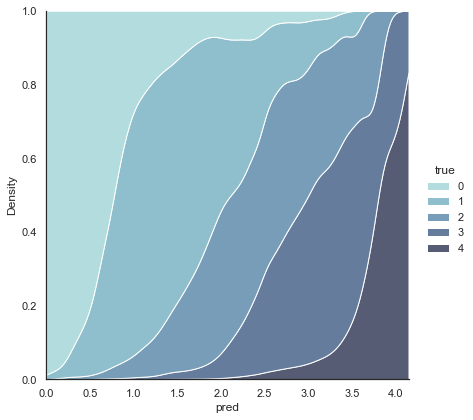

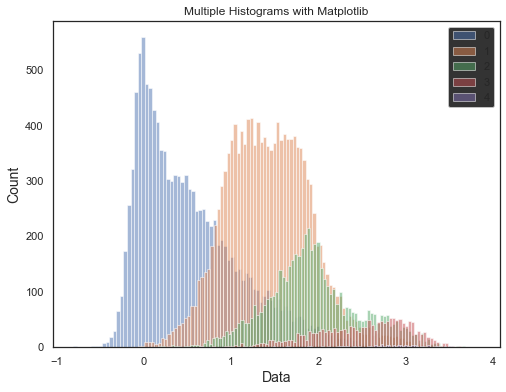

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = pd.DataFrame(yd)
df.columns = ['true']
df['pred'] = ypred

sns.displot(
    data=df,
    x="pred", hue="true",
    kind="kde", height=6,
    multiple="fill", clip=(0, None),
    palette="ch:rot=-.25,hue=1,light=.75",
)

plt.figure(figsize=(8,6))
for i in range(5):
    plt.hist(df[df['true'] == i]['pred'], bins=100, alpha=0.5, label=str(i))
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Multiple Histograms with Matplotlib")
plt.legend(loc='upper right')

# final prediction generation

In [144]:
df_e = pd.read_csv("data_for_science_KT_evaluate.csv", encoding='utf-8', sep=',')

df_e["id"] = np.arange(len(df_e))

dfe = df_e.copy()
dfe = dfe.sort_values("DATE")

In [145]:
df_e

,idx,DATE,KT_RESULT,id
0,644661,2020-04-17,NaN,0
1,292115,2020-04-18,NaN,1
2,556023,2020-04-18,NaN,2
3,233104,2020-04-18,NaN,3
4,90502,2020-04-18,NaN,4
...,...,...,...,...
33075,1119183,2020-07-11,NaN,33075
33076,473620,2020-07-11,NaN,33076
33077,327819,2020-07-11,NaN,33077
33078,452847,2020-07-11,NaN,33078


In [146]:
X_train = union.fit_transform(df_r)
X_train2 = union2.fit_transform(df_r)
X_train = np.hstack([X_train, X_train2])

[FeatureUnion] ......... (step 1 of 17) Processing year, total=   0.1s
[FeatureUnion] ....... (step 2 of 17) Processing counts, total= 1.8min
[FeatureUnion] ........ (step 3 of 17) Processing times, total= 2.1min
[FeatureUnion] ....... (step 4 of 17) Processing gender, total=   0.1s
[FeatureUnion] ..... (step 5 of 17) Processing antibody, total=  35.3s
[FeatureUnion] .......... (step 6 of 17) Processing TTD, total=   0.1s
[FeatureUnion] .... (step 7 of 17) Processing C-protein, total=  34.9s
[FeatureUnion] . (step 8 of 17) Processing Simple Blood, total=  31.0s
[FeatureUnion]  (step 9 of 17) Processing History Diases, total=   0.0s
[FeatureUnion]  (step 10 of 17) Processing Respiratory Diases, total=  32.1s
[FeatureUnion] ..... (step 11 of 17) Processing Receipe, total=  50.5s
[FeatureUnion] ....... (step 12 of 17) Processing Mazok, total=  35.0s
[FeatureUnion] ...... (step 13 of 17) Processing Reason, total= 1.1min
[FeatureUnion] .... (step 14 of 17) Processing Question, total=   1.0s

In [147]:
X_test = union.transform(dfe)
X_test2 = union2.transform(dfe)
X_test = np.hstack([X_test, X_test2])

In [149]:
#lgbm = LGBMRegressor(objective = 'regression_l1', **params)
#lgbm.fit(X_train, df_r.y.values, sample_weight = sample_weights, categorical_feature=categorical_feature)
p_all = []
for seed in seeds:
    lgbm = LGBMRegressor(objective = 'regression_l1', random_state=seed, **params)

    lgbm.fit(X_train, df_r.y.values, sample_weight = sample_weights, categorical_feature=categorical_feature)

    p_all.append(lgbm.predict(X_test))
    
preds = np.stack(p_all).mean(axis=0)


C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\hd898\Anaconda3\envs\testenv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


In [151]:
dfe["KT_RESULT"] = ['КТ-' + str(int(x)) for x in rounding(preds, [0.7, 0.4, 0.2, 0.2])]
dfe.head()

,idx,DATE,KT_RESULT,id
0,644661,2020-04-17,КТ-1,0
9834,365812,2020-04-17,КТ-2,9834
9833,435395,2020-04-17,КТ-2,9833
3,233104,2020-04-18,КТ-3,3
9849,706150,2020-04-18,КТ-2,9849


In [152]:
dfe.KT_RESULT.value_counts()

КТ-2    11092
КТ-1     9386
КТ-0     8864
КТ-3     3530
КТ-4      208
Name: KT_RESULT, dtype: int64

In [153]:
df_e = df_e.drop(columns=["KT_RESULT"])

In [154]:
df_e = df_e.merge(dfe[["id", "KT_RESULT"]], on="id", how='left')

df_e = df_e.drop(columns=["id"])

df_e.to_csv("rez.csv", encoding='utf-8', sep=',', index=False)

In [91]:
df_e

,idx,DATE,KT_RESULT
0,644661,2020-04-17,КТ-1
1,292115,2020-04-18,КТ-2
2,556023,2020-04-18,КТ-0
3,233104,2020-04-18,КТ-3
4,90502,2020-04-18,КТ-2
...,...,...,...
33075,1119183,2020-07-11,КТ-0
33076,473620,2020-07-11,КТ-1
33077,327819,2020-07-11,КТ-2
33078,452847,2020-07-11,КТ-1
